#Introduction

In this notebook we have used XceptionNet with transfer learning and fine tuning.


##Data preparation

We have splitted the dataset into 3 folders (training, validation and test) with a ratio of 75%, 15% and 10%.

We have also tried to add oversampling on the training folder in order to reach the same number of images for each class.

##Data Augmentation

We have applied data augmentation over the training set in order to avoid overfitting. This process helped to reach better results in on the validation and then the test set.

#Mounting Drive

In [ ]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


#Importing

In [ ]:
from keras.layers import Input, Lambda, Dense, Flatten
from keras.models import Model
from keras.applications.xception import preprocess_input
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.optimizers import adam_v2

import numpy as np
from glob import glob
import matplotlib.pyplot as plt
import tensorflow.keras as tfk
import random
import os
import tensorflow as tf
from PIL import Image

tfk = tf.keras
tfkl = tf.keras.layers

##Importing visualkeras library

In [ ]:
!pip install visualkeras
import visualkeras

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 989 kB 35.9 MB/s 


#Loading data and Splitting folders

Extracting the zipped dataset into the /content folder. Local colab folder speed up the reading of the files.

In [ ]:
!unzip -q /gdrive/MyDrive/ANNDL/Homework1/training_dataset_homework1.zip 

##Set the seed for reproducibility

In [ ]:
seed = 16

random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

##Importing splitfolders library

We have used splitfolders library to automatically split the folders in train, val and test with a given ratio.

In [ ]:
import os
import random

!pip install split-folders

import splitfolders
dataset_dir = 'splitted'

splitfolders.ratio('training_data_final', output=dataset_dir, seed=seed, ratio=(.75, .15, .1), group_prefix=None) # default values

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Copying files: 3542 files [00:00, 9203.23 files/s]


##Oversampling of training folder

Applying oversampling on the training folder in order to reach balanced classes

In [ ]:
import shutil
size = 550
og_dataset = 'splitted/train'
for item in os.listdir(og_dataset):
  class_path = os.path.join(og_dataset, item)
  while (len(os.listdir(class_path)) < size):
    if (len(os.listdir(class_path)) * 2 < size):
      for elem in os.listdir(class_path):
        shutil.copy2(os.path.join(class_path,elem),os.path.join(class_path,'copy_' + elem))
    else:
      elem = random.choice(os.listdir(class_path))
      shutil.copy2(os.path.join(class_path,elem),os.path.join(class_path,'copy_' + elem))


##Number of image per class

Text(0.5, 1.0, 'Number of training images per Species:')

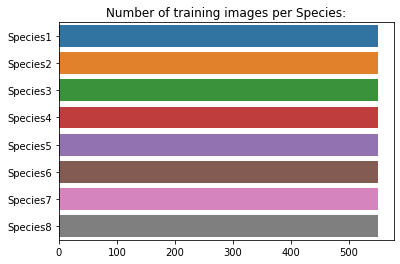

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

category_names = sorted(os.listdir(og_dataset))
nb_categories = len(category_names)
img_pr_cat = []
for category in category_names:
    folder = og_dataset + '/' + category
    img_pr_cat.append(len(os.listdir(folder)))
sns.barplot(y=category_names, x=img_pr_cat).set_title("Number of training images per Species:")

##Printing image per class

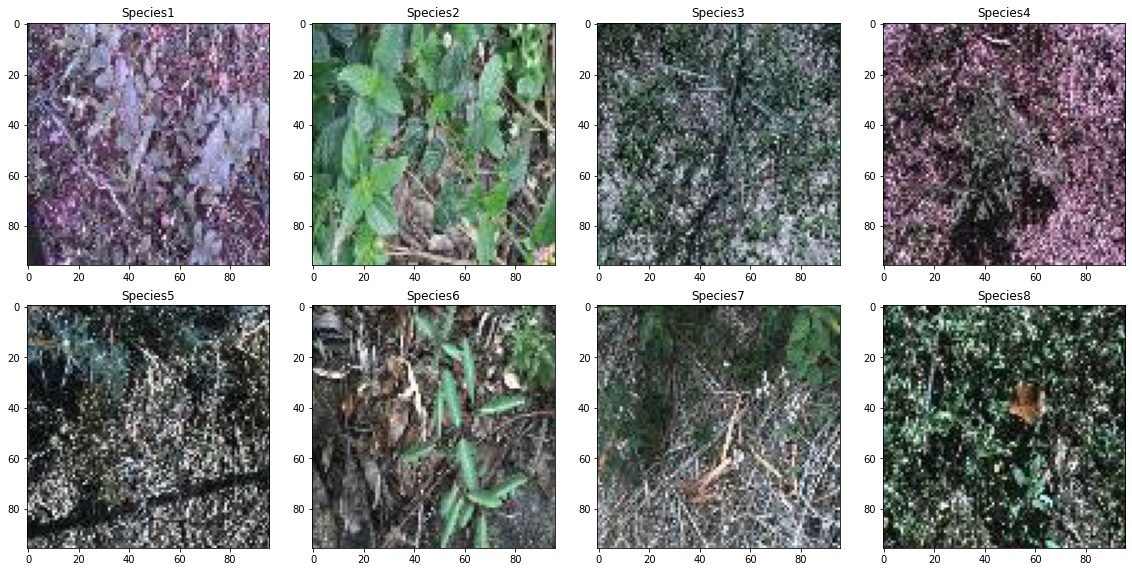

In [ ]:
training_dir = os.path.join(dataset_dir, 'train')
validation_dir = os.path.join(dataset_dir, 'val')
test_dir = os.path.join(dataset_dir, 'test') 

# Plot example images from dataset
labels = ['Species1','Species2','Species3','Species4','Species5','Species6','Species7','Species8']

from tensorflow.keras.utils import to_categorical



num_row = len(labels)//3
num_col = len(labels)//num_row
fig, axes = plt.subplots(num_row, num_col, figsize=(8*num_row,2*num_col))
for i in range(len(labels)):
  class_imgs = next(os.walk('{}/train/{}/'.format(dataset_dir, labels[i])))[2]
  class_img = class_imgs[0]
  img = Image.open('{}/train/{}/{}'.format(dataset_dir, labels[i], class_img))
  #print(np.array(img))
  ax = axes[i//num_col, i%num_col]
  ax.imshow(np.array(img))
  ax.set_title('{}'.format(labels[i]))
plt.tight_layout()
plt.show()

#Image augmentation

Defining function for getting the next batch

In [ ]:
def get_next_batch(generator):
  batch = next(generator)

  image = batch[0]
  target = batch[1]

  print("(Input) image shape:", image.shape)
  print("Target shape:",target.shape)

  image = image[0]
  target = target[0]
  target_idx = np.argmax(target)
  print()
  print("Categorical label:", target)
  print("Label:", target_idx)
  print("Class name:", labels[target_idx])
  fig = plt.figure(figsize=(6, 4))
  plt.imshow(np.uint8(image))

  return batch

Adding different type of augmentation:
* Rotation -> Random rotation of the image
* Brightness -> Adding or removing brightness on the image randomly
* Width and Height shift -> Shifting the image and removing part of the image
* Zoom -> Zooming in and out
* Horizontal and Vertical flip -> since the image are flip invariant
* Fill mode -> We have used reflect mode for adding information on not visible area of the images that have been shifted or rotated
* Preprocessing function -> We are applying the preprocessing function of the XceptionNet that scale each pixel between -1 and 1



In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Create an instance of ImageDataGenerator with Data Augmentation
aug_train_data_gen = ImageDataGenerator(rotation_range=10,
                                        brightness_range=[0.5,1.8],
                                        height_shift_range=0.3,
                                        width_shift_range=0.3,
                                        zoom_range=0.2,
                                        horizontal_flip=True,
                                        vertical_flip=True, 
                                        fill_mode='reflect',
                                        preprocessing_function = preprocess_input,
                                        ) 
aug_valid_data_gen = ImageDataGenerator(
                                    preprocessing_function = preprocess_input
                                    )
test_data_gen = ImageDataGenerator(
                                   preprocessing_function = preprocess_input
                                   )

In [ ]:

batch_size = 8

aug_train_gen = aug_train_data_gen.flow_from_directory(directory=training_dir,
                                                       target_size=(96,96),
                                                       color_mode='rgb',
                                                       classes=None,
                                                       class_mode='categorical',
                                                       batch_size=batch_size,
                                                       shuffle=True,
                                                       seed=seed)


aug_valid_gen = aug_valid_data_gen.flow_from_directory(directory=validation_dir,
                                               target_size=(96,96),
                                               color_mode='rgb',
                                               classes=None,
                                               class_mode='categorical',
                                               batch_size=batch_size,
                                               shuffle=True,
                                               seed=seed)
test_gen = test_data_gen.flow_from_directory(directory=test_dir,
                                             target_size=(96,96),
                                             color_mode='rgb',
                                             classes=None,
                                             class_mode='categorical',
                                             batch_size=batch_size,
                                             shuffle=False,
                                             seed=seed)

Found 4400 images belonging to 8 classes.
Found 527 images belonging to 8 classes.
Found 361 images belonging to 8 classes.


#Callbacks and Early stopping

We have tried using different patiance value and monitoring the validation accuracy or the validation loss for deciding wether to stop or continue the training

In [ ]:
from datetime import datetime

def create_folders_and_callbacks(model_name):
      
  callbacks = []

  es_callback  = tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=10, restore_best_weights=True)
  callbacks.append(es_callback)

  return callbacks

#Transfer learning and Dense layers

Download the Xception net with pre-trained CNN model on the imagenet dataset.

Model: "xception"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 96, 96, 3)]  0           []                               
                                                                                                  
 block1_conv1 (Conv2D)          (None, 47, 47, 32)   864         ['input_3[0][0]']                
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, 47, 47, 32)  128         ['block1_conv1[0][0]']           
 ation)                                                                                           
                                                                                                  
 block1_conv1_act (Activation)  (None, 47, 47, 32)   0           ['block1_conv1_bn[0][0]'] 

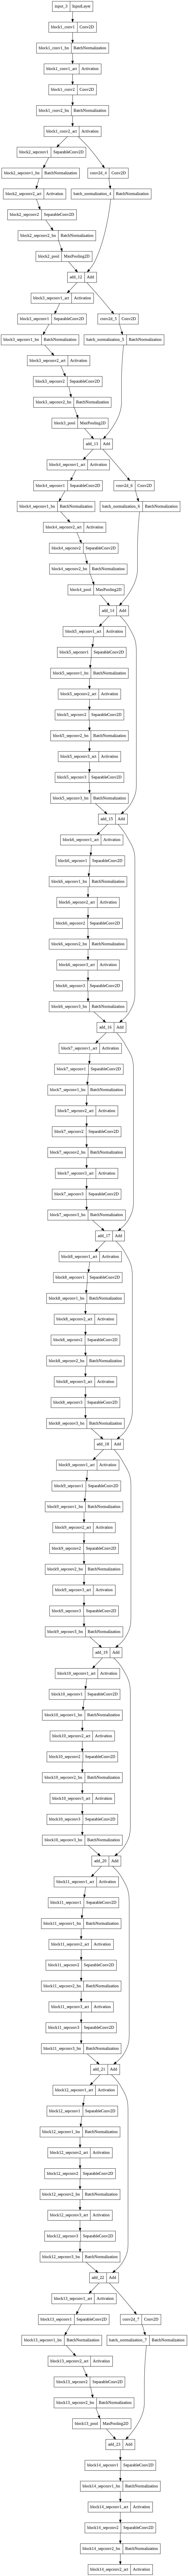

In [ ]:
supernet = tfk.applications.Xception(
    include_top=False,
    weights="imagenet",
    input_shape=(96,96,3)
)
supernet.summary()
tfk.utils.plot_model(supernet)


Adding the dense layer. We have tried different dense layers from 128 to 1024 neurons and with different activation function (relu and leaky_relu).

In [ ]:
input_shape = (96, 96, 3)
epochs = 200

In [ ]:
import tensorflow.keras.layers as tfkl
from keras.layers import Dense, GlobalAveragePooling2D

supernet.trainable = False

inputs = tfk.Input(shape=(96,96,3))
x = supernet(inputs)
x = GlobalAveragePooling2D()(x)
x = tfkl.Dropout(0.3, seed=seed)(x)
x = tfkl.Dense(
    256, 
    activation='relu',
    kernel_initializer = tfk.initializers.GlorotUniform(seed))(x)
x = tfkl.Dropout(0.3, seed=seed)(x)
output_layer = tfkl.Dense(units=len(labels), activation='softmax', kernel_initializer=tfk.initializers.GlorotUniform(seed), name='Output')(x)


tl_model = tfk.Model(inputs=inputs, outputs=output_layer, name='model')

tl_model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(), metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])
tl_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 96, 96, 3)]       0         
                                                                 
 xception (Functional)       (None, 3, 3, 2048)        20861480  
                                                                 
 global_average_pooling2d_1   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dropout_2 (Dropout)         (None, 2048)              0         
                                                                 
 dense_1 (Dense)             (None, 256)               524544    
                                                                 
 dropout_3 (Dropout)         (None, 256)               0         
                                                             

#Training the overall network

In [ ]:
tl_callbacks = create_folders_and_callbacks(model_name = 'aug_transfer_learning_balanced')

tl_history = tl_model.fit(
    x = aug_train_gen,
    epochs = epochs,
    validation_data = aug_valid_gen,
    callbacks = tl_callbacks,
).history

Epoch 1/200
550/550 [==============================] - ETA: 0s - loss: 1.6304 - accuracy: 0.3873 - precision_1: 0.5514 - recall_1: 0.1145

550/550 [==============================] - 46s 84ms/step - loss: 1.6304 - accuracy: 0.3873 - precision_1: 0.5514 - recall_1: 0.1145 - val_loss: 1.4309 - val_accuracy: 0.4801 - val_precision_1: 0.7417 - val_recall_1: 0.1689
Epoch 2/200
550/550 [==============================] - ETA: 0s - loss: 1.5637 - accuracy: 0.4218 - precision_1: 0.6061 - recall_1: 0.1486

550/550 [==============================] - 42s 77ms/step - loss: 1.5637 - accuracy: 0.4218 - precision_1: 0.6061 - recall_1: 0.1486 - val_loss: 1.3714 - val_accuracy: 0.4839 - val_precision_1: 0.7143 - val_recall_1: 0.2372
Epoch 3/200
550/550 [==============================] - ETA: 0s - loss: 1.5132 - accuracy: 0.4420 - precision_1: 0.6332 - recall_1: 0.1923

550/550 [==============================] - 40s 73ms/step - loss: 1.5132 - accuracy: 0.4420 - precision_1: 0.6332 - recall_1: 0.1923 - val_loss: 1.3887 - val_accuracy: 0.4801 - val_precision_1: 0.6502 - val_recall_1: 0.2751
Epoch 4/200
549/550 [============================>.] - ETA: 0s - loss: 1.4873 - accuracy: 0.4542 - precision_1: 0.6228 - recall_1: 0.1969

550/550 [==============================] - 42s 77ms/step - loss: 1.4874 - accuracy: 0.4543 - precision_1: 0.6224 - recall_1: 0.1970 - val_loss: 1.3180 - val_accuracy: 0.5123 - val_precision_1: 0.7005 - val_recall_1: 0.2751
Epoch 5/200
549/550 [============================>.] - ETA: 0s - loss: 1.4562 - accuracy: 0.4668 - precision_1: 0.6391 - recall_1: 0.2202

550/550 [==============================] - 42s 76ms/step - loss: 1.4556 - accuracy: 0.4668 - precision_1: 0.6396 - recall_1: 0.2202 - val_loss: 1.2774 - val_accuracy: 0.5313 - val_precision_1: 0.7394 - val_recall_1: 0.2638
Epoch 6/200
550/550 [==============================] - ETA: 0s - loss: 1.4324 - accuracy: 0.4786 - precision_1: 0.6358 - recall_1: 0.2464

550/550 [==============================] - 42s 76ms/step - loss: 1.4324 - accuracy: 0.4786 - precision_1: 0.6358 - recall_1: 0.2464 - val_loss: 1.3181 - val_accuracy: 0.4915 - val_precision_1: 0.6726 - val_recall_1: 0.2884
Epoch 7/200
550/550 [==============================] - ETA: 0s - loss: 1.4111 - accuracy: 0.4755 - precision_1: 0.6421 - recall_1: 0.2373

550/550 [==============================] - 42s 76ms/step - loss: 1.4111 - accuracy: 0.4755 - precision_1: 0.6421 - recall_1: 0.2373 - val_loss: 1.2408 - val_accuracy: 0.5503 - val_precision_1: 0.7112 - val_recall_1: 0.3131
Epoch 8/200
550/550 [==============================] - ETA: 0s - loss: 1.4130 - accuracy: 0.4693 - precision_1: 0.6361 - recall_1: 0.2448

550/550 [==============================] - 41s 75ms/step - loss: 1.4130 - accuracy: 0.4693 - precision_1: 0.6361 - recall_1: 0.2448 - val_loss: 1.2135 - val_accuracy: 0.5844 - val_precision_1: 0.6935 - val_recall_1: 0.3264
Epoch 9/200
549/550 [============================>.] - ETA: 0s - loss: 1.4175 - accuracy: 0.4745 - precision_1: 0.6402 - recall_1: 0.2500

550/550 [==============================] - 41s 74ms/step - loss: 1.4168 - accuracy: 0.4752 - precision_1: 0.6405 - recall_1: 0.2502 - val_loss: 1.2432 - val_accuracy: 0.5484 - val_precision_1: 0.7092 - val_recall_1: 0.3378
Epoch 10/200
550/550 [==============================] - ETA: 0s - loss: 1.3899 - accuracy: 0.4907 - precision_1: 0.6519 - recall_1: 0.2605

550/550 [==============================] - 42s 76ms/step - loss: 1.3899 - accuracy: 0.4907 - precision_1: 0.6519 - recall_1: 0.2605 - val_loss: 1.2158 - val_accuracy: 0.5655 - val_precision_1: 0.7178 - val_recall_1: 0.3283
Epoch 11/200
549/550 [============================>.] - ETA: 0s - loss: 1.3741 - accuracy: 0.4961 - precision_1: 0.6588 - recall_1: 0.2716

550/550 [==============================] - 42s 76ms/step - loss: 1.3738 - accuracy: 0.4964 - precision_1: 0.6589 - recall_1: 0.2714 - val_loss: 1.2028 - val_accuracy: 0.5617 - val_precision_1: 0.7143 - val_recall_1: 0.3416
Epoch 12/200
549/550 [============================>.] - ETA: 0s - loss: 1.3755 - accuracy: 0.4961 - precision_1: 0.6440 - recall_1: 0.2673

550/550 [==============================] - 41s 74ms/step - loss: 1.3754 - accuracy: 0.4959 - precision_1: 0.6442 - recall_1: 0.2675 - val_loss: 1.1854 - val_accuracy: 0.5636 - val_precision_1: 0.7280 - val_recall_1: 0.3454
Epoch 13/200
550/550 [==============================] - ETA: 0s - loss: 1.3848 - accuracy: 0.4873 - precision_1: 0.6502 - recall_1: 0.2720

550/550 [==============================] - 41s 75ms/step - loss: 1.3848 - accuracy: 0.4873 - precision_1: 0.6502 - recall_1: 0.2720 - val_loss: 1.2009 - val_accuracy: 0.5769 - val_precision_1: 0.7218 - val_recall_1: 0.3643
Epoch 14/200
549/550 [============================>.] - ETA: 0s - loss: 1.3470 - accuracy: 0.5039 - precision_1: 0.6706 - recall_1: 0.2944

550/550 [==============================] - 40s 74ms/step - loss: 1.3467 - accuracy: 0.5041 - precision_1: 0.6710 - recall_1: 0.2943 - val_loss: 1.2027 - val_accuracy: 0.5484 - val_precision_1: 0.6852 - val_recall_1: 0.3510
Epoch 15/200
550/550 [==============================] - ETA: 0s - loss: 1.3496 - accuracy: 0.5057 - precision_1: 0.6692 - recall_1: 0.2948

550/550 [==============================] - 40s 72ms/step - loss: 1.3496 - accuracy: 0.5057 - precision_1: 0.6692 - recall_1: 0.2948 - val_loss: 1.2165 - val_accuracy: 0.5389 - val_precision_1: 0.6858 - val_recall_1: 0.3397
Epoch 16/200
550/550 [==============================] - ETA: 0s - loss: 1.3550 - accuracy: 0.4973 - precision_1: 0.6740 - recall_1: 0.2866

550/550 [==============================] - 41s 75ms/step - loss: 1.3550 - accuracy: 0.4973 - precision_1: 0.6740 - recall_1: 0.2866 - val_loss: 1.2523 - val_accuracy: 0.5427 - val_precision_1: 0.6383 - val_recall_1: 0.3416
Epoch 17/200
550/550 [==============================] - ETA: 0s - loss: 1.3488 - accuracy: 0.4968 - precision_1: 0.6658 - recall_1: 0.2898

550/550 [==============================] - 41s 74ms/step - loss: 1.3488 - accuracy: 0.4968 - precision_1: 0.6658 - recall_1: 0.2898 - val_loss: 1.1561 - val_accuracy: 0.5636 - val_precision_1: 0.6987 - val_recall_1: 0.3169
Epoch 18/200
549/550 [============================>.] - ETA: 0s - loss: 1.3545 - accuracy: 0.5068 - precision_1: 0.6699 - recall_1: 0.2971

550/550 [==============================] - 41s 74ms/step - loss: 1.3547 - accuracy: 0.5068 - precision_1: 0.6696 - recall_1: 0.2970 - val_loss: 1.1910 - val_accuracy: 0.5560 - val_precision_1: 0.6894 - val_recall_1: 0.3074


#Results

##Plotting the training

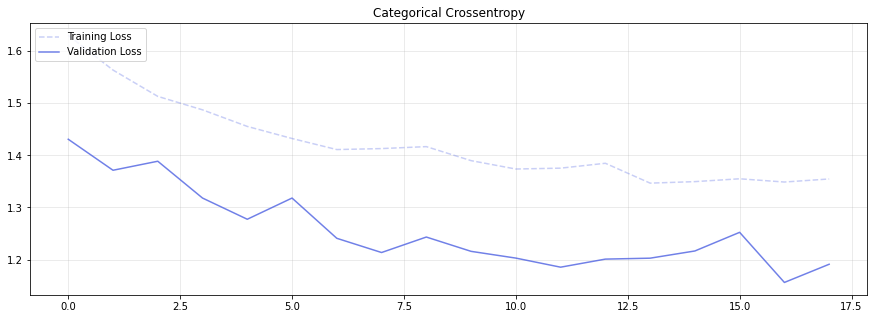

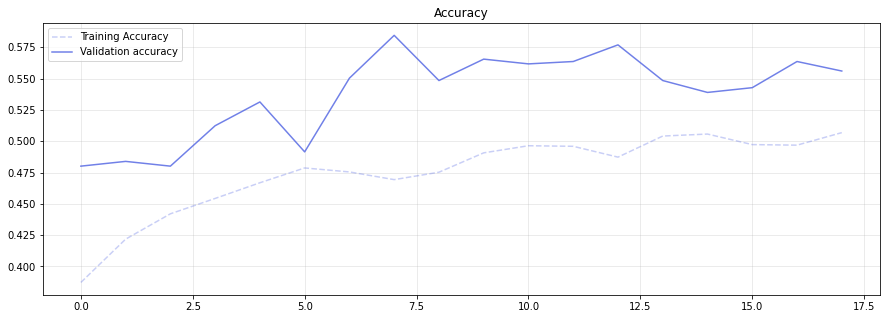

In [ ]:
plt.figure(figsize=(15,5))

plt.plot(tl_history['loss'],label = 'Training Loss', alpha=.3, color='#4D61E2', linestyle='--')
plt.plot(tl_history['val_loss'], label='Validation Loss', alpha=.8, color='#4D61E2')
plt.legend(loc='upper left')
plt.title('Categorical Crossentropy')
plt.grid(alpha=.3)

plt.figure(figsize=(15,5))

plt.plot(tl_history['accuracy'],label = 'Training Accuracy' , alpha=.3, color='#4D61E2', linestyle='--')
plt.plot(tl_history['val_accuracy'], label='Validation accuracy', alpha=.8, color='#4D61E2')
plt.legend(loc='upper left')
plt.title('Accuracy')
plt.grid(alpha=.3)

plt.show()

##Printing confusion matrix

46/46 [==============================] - 2s 18ms/step
[5 3 1 7 0 1 7 5 2 2 4 0 1 0 0 0 6 2 7 1 0 5 2 6 5 1 1 3 1 1 1 7 1 7 6 1 1
 3 2 6 1 5 6 6 1 1 3 1 1 1 6 1 1 5 6 2 1 5 5 6 1 5 6 6 1 6 5 1 0 1 3 1 1 1
 2 2 2 2 2 2 2 2 6 2 2 2 2 2 2 5 2 2 2 3 2 2 2 2 2 4 4 2 2 2 2 2 2 2 2 2 4
 1 2 2 6 2 2 4 2 4 2 3 2 3 4 2 2 3 2 2 3 1 2 3 4 3 5 7 7 3 3 2 3 3 2 2 3 1
 2 3 3 6 3 2 2 2 3 3 3 3 4 4 3 3 3 4 1 6 3 3 3 3 2 3 2 3 2 2 3 2 2 2 5 4 4
 2 4 2 2 2 2 4 2 4 4 2 4 4 2 4 4 4 3 4 4 3 4 4 6 4 2 4 4 4 3 4 2 2 4 3 2 4
 4 4 4 4 3 4 2 4 4 4 1 5 6 5 5 5 5 5 7 4 7 1 5 5 5 5 2 5 5 5 5 5 5 6 6 6 2
 1 1 6 6 7 6 6 6 6 6 6 1 2 6 6 6 2 5 6 6 6 6 1 6 6 7 6 6 3 6 6 6 6 1 6 1 2
 1 1 6 5 1 6 6 1 1 6 1 6 6 3 7 7 7 7 1 3 7 7 6 4 3 2 1 2 1 1 5 7 7 6 2 7 7
 7 7 7 5 1 0 5 7 7 7 2 7 7 7 7 1 2 0 7 7 2 7 7 7 4 2 7 4]
Accuracy: 0.5485
Precision: 0.563
Recall: 0.5358
F1: 0.5313


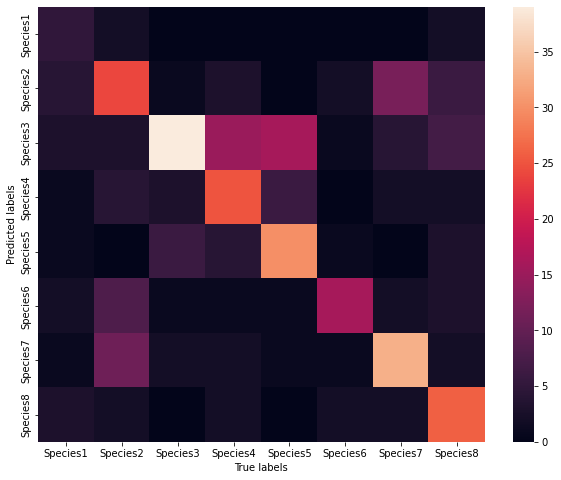

In [ ]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix

predictions = tl_model.predict(test_gen)
predicted_classes = np.argmax(predictions, axis=-1)
print(predicted_classes)

# Compute the confusion matrix

cm = (confusion_matrix(test_gen.classes, predicted_classes))

# Compute the classification metrics
accuracy = accuracy_score(test_gen.classes, predicted_classes, normalize = True)
precision = precision_score(test_gen.classes, predicted_classes, average='macro')
recall = recall_score(test_gen.classes, predicted_classes, average='macro')
f1 = f1_score(test_gen.classes, predicted_classes, average='macro')
print('Accuracy:',accuracy.round(4))
print('Precision:',precision.round(4))
print('Recall:',recall.round(4))
print('F1:',f1.round(4))

# Plot the confusion matrix
plt.figure(figsize=(10,8))
sns.heatmap(cm.T, xticklabels=labels, yticklabels=labels)
plt.xlabel('True labels')
plt.ylabel('Predicted labels')
plt.show()

##Printing evaluation for each class

In [ ]:
import sklearn.metrics
print(sklearn.metrics.classification_report(test_gen.classes, predicted_classes,output_dict = False))

              precision    recall  f1-score   support

           0       0.56      0.25      0.34        20
           1       0.46      0.44      0.45        54
           2       0.44      0.75      0.56        52
           3       0.58      0.48      0.53        52
           4       0.67      0.56      0.61        54
           5       0.47      0.70      0.56        23
           6       0.62      0.60      0.61        55
           7       0.70      0.51      0.59        51

    accuracy                           0.55       361
   macro avg       0.56      0.54      0.53       361
weighted avg       0.57      0.55      0.55       361



##Saving the generated model

In [ ]:
# Save the best model
model_dir = '/gdrive/MyDrive/ANNDL/Homework1/models/Franc/XceptionNet_Submit'
tl_model.save(model_dir)

#Fine tuning

Load the previously saved model

In [ ]:
tl_model = tfk.models.load_model(model_dir)
tl_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 96, 96, 3)]       0         
                                                                 
 xception (Functional)       (None, 3, 3, 2048)        20861480  
                                                                 
 global_average_pooling2d_1   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dropout_2 (Dropout)         (None, 2048)              0         
                                                                 
 dense_1 (Dense)             (None, 256)               524544    
                                                                 
 dropout_3 (Dropout)         (None, 256)               0         
                                                             

##Printing Xception layers

We have started to unlock 10 to 20 layers for fine tuning. At the end the best results was given by unlocking all layers.



In [ ]:
tl_model.get_layer('xception').trainable = True
for i, layer in enumerate(tl_model.get_layer('xception').layers):
   print(i, layer.name, layer.trainable)

0 input_3 True
1 block1_conv1 True
2 block1_conv1_bn True
3 block1_conv1_act True
4 block1_conv2 True
5 block1_conv2_bn True
6 block1_conv2_act True
7 block2_sepconv1 True
8 block2_sepconv1_bn True
9 block2_sepconv2_act True
10 block2_sepconv2 True
11 block2_sepconv2_bn True
12 conv2d_4 True
13 block2_pool True
14 batch_normalization_4 True
15 add_12 True
16 block3_sepconv1_act True
17 block3_sepconv1 True
18 block3_sepconv1_bn True
19 block3_sepconv2_act True
20 block3_sepconv2 True
21 block3_sepconv2_bn True
22 conv2d_5 True
23 block3_pool True
24 batch_normalization_5 True
25 add_13 True
26 block4_sepconv1_act True
27 block4_sepconv1 True
28 block4_sepconv1_bn True
29 block4_sepconv2_act True
30 block4_sepconv2 True
31 block4_sepconv2_bn True
32 conv2d_6 True
33 block4_pool True
34 batch_normalization_6 True
35 add_14 True
36 block5_sepconv1_act True
37 block5_sepconv1 True
38 block5_sepconv1_bn True
39 block5_sepconv2_act True
40 block5_sepconv2 True
41 block5_sepconv2_bn True
42 b

In [ ]:
tl_model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(1e-4), metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

##Train the model

In [ ]:
tl_history = tl_model.fit(
    x = aug_train_gen ,
    epochs = 200,
    validation_data = aug_valid_gen,
    callbacks = [tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=15, verbose=2 , restore_best_weights=True)]
).history

Epoch 1/200
550/550 [==============================] - 38s 52ms/step - loss: 1.5772 - accuracy: 0.4039 - precision_2: 0.6024 - recall_2: 0.1584 - val_loss: 1.5175 - val_accuracy: 0.5901 - val_precision_2: 0.6941 - val_recall_2: 0.4649
Epoch 2/200
550/550 [==============================] - 26s 46ms/step - loss: 1.2889 - accuracy: 0.5309 - precision_2: 0.6951 - recall_2: 0.3336 - val_loss: 1.0053 - val_accuracy: 0.6774 - val_precision_2: 0.7410 - val_recall_2: 0.5863
Epoch 3/200
550/550 [==============================] - 27s 49ms/step - loss: 1.1738 - accuracy: 0.5802 - precision_2: 0.7141 - recall_2: 0.4002 - val_loss: 0.8893 - val_accuracy: 0.6812 - val_precision_2: 0.7848 - val_recall_2: 0.5674
Epoch 4/200
550/550 [==============================] - 26s 48ms/step - loss: 1.0493 - accuracy: 0.6118 - precision_2: 0.7429 - recall_2: 0.4727 - val_loss: 0.8686 - val_accuracy: 0.7192 - val_precision_2: 0.7894 - val_recall_2: 0.6471
Epoch 5/200
550/550 [==============================] - 26s 4

##Saving the best model

In [ ]:
tl_model.save(model_dir + 'tuned')

#Test

In [ ]:
model_to_be_tested_metrics = tl_model.evaluate(test_gen, return_dict=True)

46/46 [==============================] - 1s 17ms/step - loss: 0.5594 - accuracy: 0.8393 - precision_2: 0.8523 - recall_2: 0.8310


##Confusion matrix

46/46 [==============================] - 1s 11ms/step
[7 3 3 7 1 0 7 3 0 0 0 0 1 1 0 0 7 0 0 1 1 1 6 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 3 1 1 1 1 1 1 1 1 1 1 1 1 6 1 3 1 1 1 1 3 1 1 1 1 2 1 1 1 1 1 1 1 1 6 1 1
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 3 2
 2 2 2 2 2 2 2 2 4 2 2 2 2 4 2 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 2 7 3 3 3 3 7
 4 3 2 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 4 4 3 3 3 4 3 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 2 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 3 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 0 4 4 4 4 4 4 4 4 3 5 5 5 5 5 1 5 5 5 1 6 5 5 5 5 3 5 5 5 5 5 5 6 6 6 6
 3 6 7 6 3 6 6 3 6 1 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 1 6
 6 6 6 5 6 6 6 3 6 6 6 6 6 6 7 7 7 7 0 7 7 7 1 0 7 7 1 1 7 7 7 7 7 7 7 6 7
 7 7 7 1 7 0 7 7 7 7 7 7 7 0 7 7 6 7 7 7 7 5 3 7 7 7 7 0]
Accuracy: 0.8393
Precision: 0.8241
Recall: 0.8044
F1: 0.8113


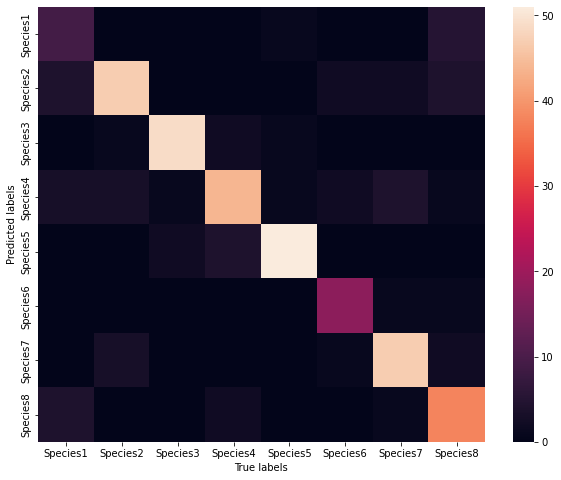

In [ ]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix

predictions = tl_model.predict(test_gen)
predicted_classes = np.argmax(predictions, axis=-1)
print(predicted_classes)

# Compute the confusion matrix

cm = (confusion_matrix(test_gen.classes, predicted_classes))

# Compute the classification metrics
accuracy = accuracy_score(test_gen.classes, predicted_classes, normalize = True)
precision = precision_score(test_gen.classes, predicted_classes, average='macro')
recall = recall_score(test_gen.classes, predicted_classes, average='macro')
f1 = f1_score(test_gen.classes, predicted_classes, average='macro')
print('Accuracy:',accuracy.round(4))
print('Precision:',precision.round(4))
print('Recall:',recall.round(4))
print('F1:',f1.round(4))

# Plot the confusion matrix
plt.figure(figsize=(10,8))
sns.heatmap(cm.T, xticklabels=labels, yticklabels=labels)
plt.xlabel('True labels')
plt.ylabel('Predicted labels')
plt.show()

##Accuracy per class

In [ ]:
import sklearn.metrics
print(sklearn.metrics.classification_report(test_gen.classes, predicted_classes,output_dict = False))

              precision    recall  f1-score   support

           0       0.60      0.45      0.51        20
           1       0.80      0.87      0.83        54
           2       0.92      0.94      0.93        52
           3       0.75      0.85      0.79        52
           4       0.89      0.94      0.92        54
           5       0.90      0.78      0.84        23
           6       0.89      0.85      0.87        55
           7       0.84      0.75      0.79        51

    accuracy                           0.84       361
   macro avg       0.82      0.80      0.81       361
weighted avg       0.84      0.84      0.84       361

